In [5]:
from math import pi
import numpy as np

class NFOV():
    def __init__(self, height=400, width=800):
        self.FOV = [0.45, 0.45]
        self.PI = pi
        self.PI_2 = pi * 0.5
        self.PI2 = pi * 2.0
        self.height = height
        self.width = width
        self.screen_points = self._get_screen_img()

    def _get_coord_rad(self, isCenterPt, center_point=None):
        return (center_point * 2 - 1) * np.array([self.PI, self.PI_2]) \
            if isCenterPt \
            else \
            (self.screen_points * 2 - 1) * np.array([self.PI, self.PI_2]) * (
                np.ones(self.screen_points.shape) * self.FOV)

    def _get_screen_img(self):
        xx, yy = np.meshgrid(np.linspace(0, 1, self.width), np.linspace(0, 1, self.height))
        return np.array([xx.ravel(), yy.ravel()]).T

    def _calcSphericaltoGnomonic(self, convertedScreenCoord):
        x = convertedScreenCoord.T[0]
        y = convertedScreenCoord.T[1]

        rou = np.sqrt(x ** 2 + y ** 2)
        c = np.arctan(rou)
        sin_c = np.sin(c)
        cos_c = np.cos(c)

        lat = np.arcsin(cos_c * np.sin(self.cp[1]) + (y * sin_c * np.cos(self.cp[1])) / rou)
        lon = self.cp[0] + np.arctan2(x * sin_c, rou * np.cos(self.cp[1]) * cos_c - y * np.sin(self.cp[1]) * sin_c)

        lat = (lat / self.PI_2 + 1.) * 0.5
        lon = (lon / self.PI + 1.) * 0.5

        return np.array([lon, lat]).T

    def _bilinear_interpolation(self, screen_coord):
        uf = np.mod(screen_coord.T[0],1) * self.frame_width  # long - width
        vf = np.mod(screen_coord.T[1],1) * self.frame_height  # lat - height

        x0 = np.floor(uf).astype(int)  # coord of pixel to bottom left
        y0 = np.floor(vf).astype(int)
        x2 = np.add(x0, np.ones(uf.shape).astype(int))  # coords of pixel to top right
        y2 = np.add(y0, np.ones(vf.shape).astype(int))

        base_y0 = np.multiply(y0, self.frame_width)
        base_y2 = np.multiply(y2, self.frame_width)

        A_idx = np.add(base_y0, x0)
        B_idx = np.add(base_y2, x0)
        C_idx = np.add(base_y0, x2)
        D_idx = np.add(base_y2, x2)

        flat_img = np.reshape(self.frame, [-1, self.frame_channel])

        A = np.take(flat_img, A_idx, axis=0)
        B = np.take(flat_img, B_idx, axis=0)
        C = np.take(flat_img, C_idx, axis=0)
        D = np.take(flat_img, D_idx, axis=0)

        wa = np.multiply(x2 - uf, y2 - vf)
        wb = np.multiply(x2 - uf, vf - y0)
        wc = np.multiply(uf - x0, y2 - vf)
        wd = np.multiply(uf - x0, vf - y0)

        # interpolate
        AA = np.multiply(A, np.array([wa, wa, wa]).T)
        BB = np.multiply(B, np.array([wb, wb, wb]).T)
        CC = np.multiply(C, np.array([wc, wc, wc]).T)
        DD = np.multiply(D, np.array([wd, wd, wd]).T)
        nfov = np.reshape(np.round(AA + BB + CC + DD).astype(np.uint8), [self.height, self.width, 3])
#        import matplotlib.pyplot as plt
#        plt.imshow(nfov)
#        plt.show()
        return nfov

    def toNFOV(self, frame, center_point):
        self.frame = frame
        self.frame_height = frame.shape[0]
        self.frame_width = frame.shape[1]
        self.frame_channel = frame.shape[2]

        self.cp = self._get_coord_rad(center_point=center_point, isCenterPt=True)
        convertedScreenCoord = self._get_coord_rad(isCenterPt=False)
        spericalCoord = self._calcSphericaltoGnomonic(convertedScreenCoord)
        return self._bilinear_interpolation(spericalCoord)



C:\Users\aayus\AppData\Local\Temp\ipykernel_10888\4164722949.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = im.imread('Street View Images/Street View 360_1.jpg')


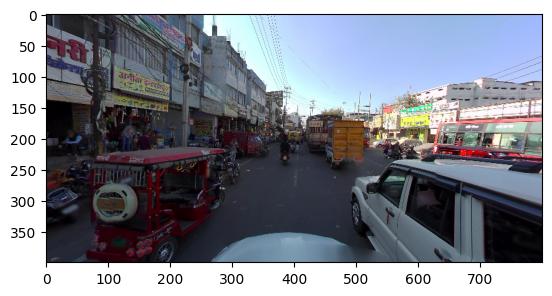

In [6]:
import imageio as im
import matplotlib.pyplot as plt
img = im.imread('Street View Images/Street View 360_1.jpg')
nfov = NFOV()
center_point = np.array([0.5, 0.5])  # camera center point (valid range [0,1])
plt.imshow(nfov.toNFOV(img, center_point))
plt.show()

In [10]:
import os
file = os.listdir('Street View Images/')

C:\Users\aayus\AppData\Local\Temp\ipykernel_10888\1063651084.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = im.imread('Street View Images/Street View 360_1.jpg')


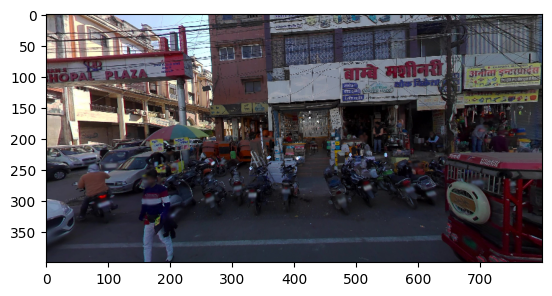

In [12]:
img = im.imread('Street View Images/Street View 360_1.jpg')
nfov = NFOV()
center_point = np.array([0.25, 0.5])  # camera center point (valid range [0,1])
plt.imshow(nfov.toNFOV(img, center_point))
plt.show()

C:\Users\aayus\AppData\Local\Temp\ipykernel_10888\2428846360.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = im.imread('Street View Images/Street View 360_1.jpg')


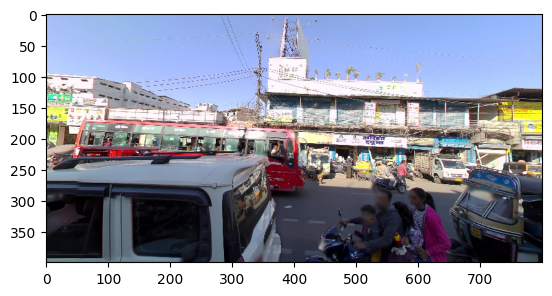

In [11]:
img = im.imread('Street View Images/Street View 360_1.jpg')
nfov = NFOV()
center_point = np.array([0.75, 0.5])  # camera center point (valid range [0,1])
plt.imshow(nfov.toNFOV(img, center_point))
plt.show()